<a href="https://colab.research.google.com/github/Walaga/pothole-detection/blob/master/Pothole_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Walaga/pothole-detection.git

Cloning into 'pothole-detection'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
!unzip /content/pothole-detection/images.zip

In [3]:
import json
import os
import csv
import math


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import shutil
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm
from PIL import Image

In [4]:
def get_json(dir):
    """Get *.json files in dir."""
    jsons = []
    for file in os.listdir(dir):
        if file.endswith(".json"):
            jsons.append(os.path.join(dir, file))
    return jsons

def process_labelbox_json(jsons):
    """
        Parse Labelbox labels JSON.
    """
    df = pd.DataFrame(columns=['file_name',
                                'xmin',
                                'ymin',
                                'width',
                                'height'])
    
    # Extract
    for file in jsons:
        f = open(file, 'r')
        data = json.load(f)
        f.close()
        
        for item in tqdm(data, desc="Processing data: "):
            # print ('Working')
            item_label = item['Label']

            # check if the item['Label'] is empty. If empty, continue to the next item.
            if bool(item_label)==False:
                continue

            # check if the item['Label']['objects'] is empty, if so, proceed to the next item.
            elif bool(item_label['objects']==False):
                continue

            # All  is well, execute the loop below for all the bounding boxes.
            #Image file_name
            file_name = item['External ID']

            #Extract the bounding boxes
            for bounding_box in item_label['objects']:
                # print(dictionary['bbox'])

                # class_name = bounding_box['title'].replace(" ", "")

                ymin = bounding_box['bbox']['top']
                xmin = bounding_box['bbox']['left']

                height = bounding_box['bbox']['height']
                width = bounding_box['bbox']['width']

                df = df.append({"file_name": file_name,
                                "xmin": xmin,
                                "ymin": ymin,
                                "width": width,
                                "height": height},
                                ignore_index=True)
            
    return df
    

   

def make_dirs(dirs):
    """Make directories that don't exist."""
    for dir in dirs:
        if not os.path.isdir(dir):
            os.mkdir(dir)
            

def split_indices(x, train=0.8, test=0.0, validate=0.2, shuffle=True):  
    # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices

def split_files(file_names,train=0.8, test=0.2, validate=0.0):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_names))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_names, train=train, test=test, validate=validate)
    train = []
    test = []
    val = []
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            for ix in item:
                if key == 'train':
                  train.append(file_names[ix])
                if key == 'test':
                    test.append(file_names[ix])
                if key == 'val':
                    val.append(file_names[ix])

    return train, test, val
# create coco file
def make_coco_file(labels, categories, filenames):
    """Creates a COCO format data structure."""

    classes = sorted(categories)
    category_list = []

    # COCO ANNOTATION FORMAT
    for i, category in enumerate(classes):
        foo = {}
        foo["supercategory"] = "None"
        foo["id"] = i + 1 # COCO is one-indexed
        foo["name"] = category
        category_list.append(foo)

    # COCO VARIABLE
    COCO_DATA = {}
    COCO_DATA["type"] = "instances"
    COCO_DATA["images"] = []
    COCO_DATA["annotations"] = []
    COCO_DATA["categories"] = category_list

    image_id = 0 # Image id
    annotation_id = 0 # Annotation id

    label = "pothole" # Different implementation for more than one label

    # Iterate through the filenames
    for file_name in tqdm(filenames, desc="Creating COCO: "):

        # Add to COCO images
        temp = {}
        temp["file_name"] = file_name
        temp["height"] = 512 # Could be dynamic
        temp["width"]  = 512
        temp["id"]  = image_id
        COCO_DATA["images"].append(temp)

        # Bboxes
        image_bboxes = labels[labels.file_name == file_name]

        for _, row in image_bboxes.iterrows():
            xmin = float(row["xmin"])
            ymin = float(row["ymin"])
            width = float(row["width"])
            height = float(row["height"])

            temp = {}
            temp["id"] = annotation_id
            annotation_id += 1
            temp["image_id"] = image_id
            temp["segmentation"] = []
            temp["ignore"] = 0
            temp["area"] = width * height
            temp["iscrowd"] = 0
            temp["bbox"] = [xmin, ymin, width, height]
            temp["category_id"] = classes.index(label) + 1 
            # There is only one class
            COCO_DATA["annotations"].append(temp)
        # Update image id
        image_id += 1
        # Return coco data format
    return COCO_DATA

def create_file(coco_data, output_file):
    """Create JSON file of the COCO_DATA."""
    f = open(output_file, 'w')
    json_str = json.dumps(coco_data, indent=4)
    f.write(json_str)
    f.close()
    
def move_files(files, source, dest):
    """
        Move files from the source directory to the destination directory.
    """
    for filename in files:
        copyfile(os.path.join(source, filename),
                 os.path.join(dest, filename))
      
        
"""def create_yolo_labels(labels, dir, filenames, kind):
    Create yolo labels for each image.
  
    yolo_directory = os.path.join(dir, kind)
    make_dirs([yolo_directory])
    
    for file_name in tqdm(filenames, desc='Images'):
        #name of file to save the bounding box items
        label_name = str(f'{Path(file_name).stem}.txt')
        
        image_width, image_height = 512, 512
        

        #create label file for current image
        with open(os.path.join(yolo_directory, label_name), 'w') as file:

            # Bboxes
            image_bboxes = labels[labels.file_name == file_name]
            
            for _, row in image_bboxes.iterrows():
                xmin = float(row["xmin"])
                ymin = float(row["ymin"])
                width = float(row["width"])
                height = float(row["height"])
            
                   
                xmax = xmin + width
                ymax = ymin + height

                x_center = 0.5*(xmin + xmax)
                y_center = 0.5*(ymin + ymax)

                #Normalize with image dimensions
                x_center_norm =  x_center/image_width
                width_norm = width/image_width

                y_center_norm = y_center/image_height
                height_norm = height/image_height
                # <object-class> <x> <y> <width> <height> Note <> - normalized
                file.write('%g %.6f %.6f %.6f %.6f\n' % (0, x_center_norm, y_center_norm,
                                                     width_norm, height_norm)"""
              
def to_csv(labels, filenames, kind):
    """
        Save CSV files.
    """
    dir_path = os.path.join(os.getcwd(), 'csv')
    make_dirs([dir_path])
    csv_name = f'{kind}_labels.csv'
    df = pd.DataFrame()
    
    for file in tqdm(filenames, desc="Processing *.csv"):
        temp = labels[labels.file_name == file]
        df = df.append(temp, ignore_index=True)
        
    df.to_csv(os.path.join(dir_path, csv_name), index=False)

def save_file_lists(dir, files, kind):
    """
        Saves the test|train filenames to disc.
    """
    with open(os.path.join(dir, f'{kind}.txt'), 'w') as file:
        for item in files:
            file.write('%s\n' % item)

# Display utilities
def process_images(filenames, labels, r_images):
    n = np.arange(len(filenames))
    np.random.shuffle(n)
    indices = np.random.choice(n, r_images)
    
    temp = [] # Holds the random images
    
    # Extract information
    for index in indices:
        # Probably inefficient
        file_name = filenames[index]
        image_id = file_name.split('/')[-1]
        
        # Bboxes
        image_bboxes = labels[labels.file_name == image_id]
        
        bboxes = []
        for _, row in image_bboxes.iterrows():
                xmin = float(row["xmin"])
                ymin = float(row["ymin"])
                width = float(row["width"])
                height = float(row["height"])
                
                bboxes.append([xmin, ymin, width, height])
        temp.append((file_name, bboxes))
    # Return a pair of the filename and it's bounding boxes.
    return temp

def display_image(image, bboxes, subplot):
    """Display a single image."""
    ax = plt.subplot(*subplot)
    plt.axis('off')
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], \
                                 linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(image)
    return (subplot[0], subplot[1], subplot[2] + 1)

def display_images(files):
    """Displays a batch of images."""
    rows = int(math.sqrt(len(files)))  
    cols = len(files) // rows
    
    FIGSIZE = 13.0
    SPACING = 0.1
    
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))
    
    for file, bboxes in files[:rows * cols]:
        image = Image.open(file)
        subplot = display_image(image, bboxes, subplot)
        
    plt.tight_layout()
    plt.show()

                


In [5]:
# Existing directories
CWD = os.getcwd()
OUTPUT_DIR = os.path.join(CWD, 'dataset')
DATASET_DIR = os.path.join(CWD, 'images')
COCO_JSONS_DIR = os.path.join(CWD, 'labels')
LABEL_BOX_JSONS = os.path.join(CWD, 'labelbox')

# Directories to make.
TRAIN_DIR = os.path.join(OUTPUT_DIR, 'train')
TEST_DIR = os.path.join(OUTPUT_DIR, 'test')
VAL_DIR = os.path.join(OUTPUT_DIR, 'val')
COCO_DIR = os.path.join(OUTPUT_DIR, 'COCO')
YOLO_DIR = os.path.join(OUTPUT_DIR, 'YOLO')

In [6]:
dirs =  [OUTPUT_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, COCO_DIR, YOLO_DIR]
make_dirs(dirs)

In [7]:
labelbox_jsons = get_json(LABEL_BOX_JSONS)
labelbox_df = process_labelbox_json(labelbox_jsons)

Processing data: 100%|██████████| 881/881 [00:07<00:00, 125.08it/s]


In [8]:
labelbox_df.shape


(2306, 5)

In [9]:
file_names = list(labelbox_df.file_name.unique())
len(file_names)

838

In [10]:
files = []
for file_name in file_names:
    files.append(os.path.join(DATASET_DIR, file_name))

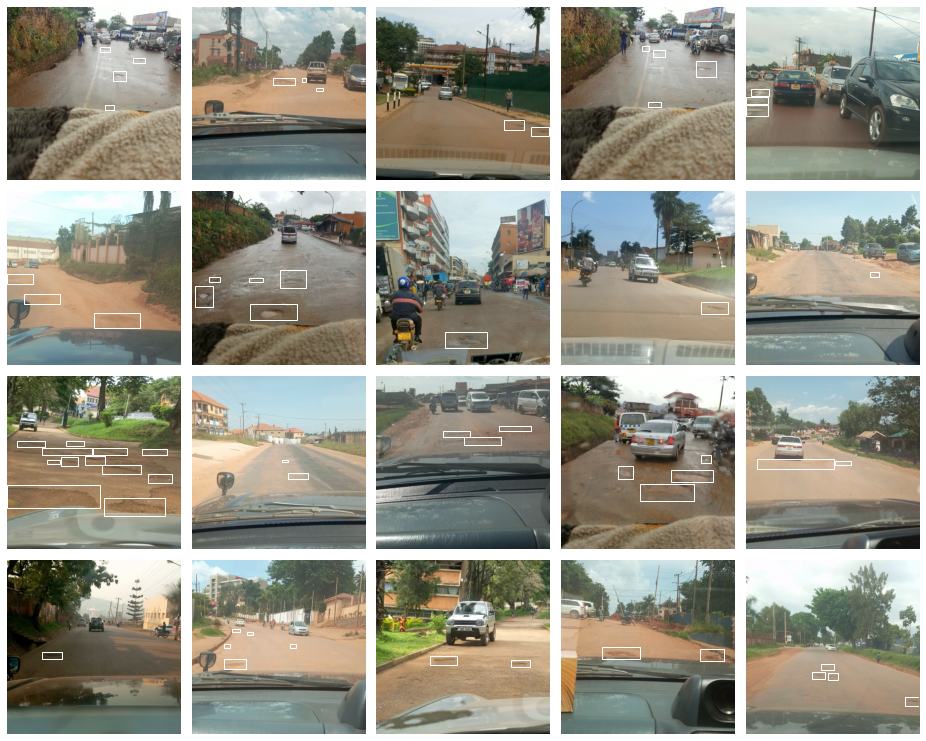

In [11]:
dumps = process_images(files, labelbox_df, 21)
display_images(dumps)

In [12]:
train, test, val = split_files(file_names,train=0.7, test=0.1, validate=0.2)

In [13]:
len(test), len(train), len(val)

(84, 587, 167)

In [14]:
categories = ['pothole']

In [15]:
TRAIN_COCO = make_coco_file(labelbox_df, categories, train)
output_annotation_file = os.path.join(COCO_DIR, "instances_train.json")
create_file(TRAIN_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 587/587 [00:00<00:00, 1214.90it/s]


In [16]:
TEST_COCO = make_coco_file(labelbox_df, categories, test)
output_annotation_file = os.path.join(COCO_DIR, "instances_test.json")
create_file(TEST_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 84/84 [00:00<00:00, 1251.48it/s]


In [17]:
VAL_COCO = make_coco_file(labelbox_df, categories, val)
output_annotation_file = os.path.join(COCO_DIR, "instances_val.json")
create_file(VAL_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 167/167 [00:00<00:00, 1111.13it/s]


In [18]:
save_file_lists(OUTPUT_DIR, train, 'train')
save_file_lists(OUTPUT_DIR, test, 'test')
save_file_lists(OUTPUT_DIR,  val, 'val')

In [19]:
to_csv(labelbox_df, train, 'train')

Processing *.csv: 100%|██████████| 587/587 [00:00<00:00, 937.77it/s]


In [20]:
to_csv(labelbox_df, test, 'test')

Processing *.csv: 100%|██████████| 84/84 [00:00<00:00, 951.64it/s]


In [23]:
to_csv(labelbox_df, val, 'val')

Processing *.csv: 100%|██████████| 167/167 [00:00<00:00, 861.09it/s]


In [24]:
move_files(train, DATASET_DIR, TRAIN_DIR)
move_files(test, DATASET_DIR, TEST_DIR)
move_files(val, DATASET_DIR, VAL_DIR)

In [25]:
# Set up environment
import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
  !pip install -r requirements.txt
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
else:
  !git pull
sys.path.append('.')
!pip install -r requirements.txt
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Cloning into 'automl'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 116 (delta 13), reused 30 (delta 0), pack-reused 0
Receiving objects: 100% (116/116), 2.02 MiB | 2.05 MiB/s, done.
Resolving deltas: 100% (13/13), done.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_bl7gkz1
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_bl7gkz1
     |████████████████████████████████| 5.5MB 5.6MB/s 
     |████████████████████████████████| 276kB 44.4MB/s 
     |████████████████████████████████| 1.1MB 43.3MB/s 
     |████████████████████████████████| 122kB 48.0MB/s 
     |████████████████████████████████| 174kB 44.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=c0bfce5887d54eed1ea5dddd9e2f38dd2e455133ea563875d1a170fb6a02c839
  Stored in directory: /root/.cache/pip/whe

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-gjoxu35b
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-gjoxu35b
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266458 sha256=ad89452f50ec508563f5b0b2374e507f964c27401d740d838e92eaaca7dab17c
  Stored in directory: /tmp/pip-ephem-wheel-cache-45fw8w3s/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-h0k5upnl
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-h0k5upnl
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=d9339e34ec37b1fe7dc9495db6a73895403d4f434a5236bd5d1b7fd346e28ac9
  S

In [27]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
    --image_dir=/content/dataset/train \
    --object_annotations_file=/content/dataset/COCO/instances_train.json \
    --output_file_prefix=tfrecord/train  \
    --num_shards=16

2020-11-20 08:40:58.354315: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1120 08:40:59.697022 139634777048960 create_coco_tfrecord.py:285] writing to output path: tfrecord/train
I1120 08:40:59.712763 139634777048960 create_coco_tfrecord.py:215] Building bounding box index.
I1120 08:40:59.713264 139634777048960 create_coco_tfrecord.py:226] 0 images are missing bboxes.
I1120 08:40:59.741219 139634777048960 create_coco_tfrecord.py:323] On image 0 of 587
I1120 08:40:59.814944 139634777048960 create_coco_tfrecord.py:323] On image 100 of 587
I1120 08:40:59.887410 139634777048960 create_coco_tfrecord.py:323] On image 200 of 587
I1120 08:40:59.956338 139634777048960 create_coco_tfrecord.py:323] On image 300 of 587
I1120 08:41:00.027486 139634777048960 create_coco_tfrecord.py:323] On image 400 of 587
I1120 08:41:00.096493 139634777048960 create_coco_tfrecord.py:323] On image 500 of 587
I1120 08:41:00.229344 13963477704896

In [28]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
    --image_dir=/content/dataset/test \
    --object_annotations_file=/content/dataset/COCO/instances_test.json \
    --output_file_prefix=tfrecord/test \
    --num_shards=16

mkdir: cannot create directory ‘tfrecord’: File exists
2020-11-20 08:41:13.059849: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1120 08:41:14.400199 139939586959232 create_coco_tfrecord.py:285] writing to output path: tfrecord/test
I1120 08:41:14.403730 139939586959232 create_coco_tfrecord.py:215] Building bounding box index.
I1120 08:41:14.403906 139939586959232 create_coco_tfrecord.py:226] 0 images are missing bboxes.
I1120 08:41:14.435663 139939586959232 create_coco_tfrecord.py:323] On image 0 of 84
I1120 08:41:14.518734 139939586959232 create_coco_tfrecord.py:335] Finished writing, skipped 0 annotations.


In [29]:
!mkdir tfrecord
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
    --image_dir=/content/dataset/val\
    --object_annotations_file=/content/dataset/COCO/instances_val.json \
    --output_file_prefix=tfrecord/val \
    --num_shards=16

mkdir: cannot create directory ‘tfrecord’: File exists
2020-11-20 08:41:36.087997: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1120 08:41:37.430343 140455635564416 create_coco_tfrecord.py:285] writing to output path: tfrecord/val
I1120 08:41:37.436009 140455635564416 create_coco_tfrecord.py:215] Building bounding box index.
I1120 08:41:37.436237 140455635564416 create_coco_tfrecord.py:226] 0 images are missing bboxes.
I1120 08:41:37.462527 140455635564416 create_coco_tfrecord.py:323] On image 0 of 167
I1120 08:41:37.536168 140455635564416 create_coco_tfrecord.py:323] On image 100 of 167
I1120 08:41:37.651102 140455635564416 create_coco_tfrecord.py:335] Finished writing, skipped 0 annotations.


In [30]:
MODEL = 'efficientdet-d0'

# Download the specified model
def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
        !tar zxf {m}.tar.gz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

ckpt_path = download(MODEL)

--2020-11-20 08:41:53--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M  9.94MB/s    in 2.8s    

2020-11-20 08:41:58 (9.94 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]



In [31]:
!pwd

/content/automl/efficientdet


In [32]:
!mkdir general_experiments

In [33]:
%cd ./general_experiments/

/content/automl/efficientdet/general_experiments


In [58]:
!mkdir exp01

In [35]:
%cd ..

/content/automl/efficientdet


In [61]:
%load_ext tensorboard
%tensorboard --logdir /content/automl/efficientdet/general_experiments/exp01

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 471), started 6:38:36 ago. (Use '!kill 471' to kill it.)

<IPython.core.display.Javascript object>

In [60]:
# Training cell
!python main.py --mode=train_and_eval --training_file_pattern=tfrecord/train* \
    --validation_file_pattern=tfrecord/val* \
    --model_name='efficientdet-d0' \
    --model_dir=general_experiments/exp01/{MODEL}-finetune \
    --ckpt='efficientdet-d0' --train_batch_size=10 \
    --eval_batch_size=20 --eval_samples=167 \
    --num_examples_per_epoch=587 --num_epochs=50 \
    --hparams=config.yaml

Streaming output truncated to the last 5000 lines.
I1120 14:55:57.613197 140589393065856 efficientdet_keras.py:725] fnode 5 : {'feat_level': 5, 'inputs_offsets': [2, 6, 9]}
I1120 14:55:57.614006 140589393065856 efficientdet_keras.py:725] fnode 6 : {'feat_level': 6, 'inputs_offsets': [3, 5, 10]}
I1120 14:55:57.614790 140589393065856 efficientdet_keras.py:725] fnode 7 : {'feat_level': 7, 'inputs_offsets': [4, 11]}
I1120 14:55:57.616162 140589393065856 efficientdet_keras.py:725] fnode 0 : {'feat_level': 6, 'inputs_offsets': [3, 4]}
I1120 14:55:57.617012 140589393065856 efficientdet_keras.py:725] fnode 1 : {'feat_level': 5, 'inputs_offsets': [2, 5]}
I1120 14:55:57.617799 140589393065856 efficientdet_keras.py:725] fnode 2 : {'feat_level': 4, 'inputs_offsets': [1, 6]}
I1120 14:55:57.618554 140589393065856 efficientdet_keras.py:725] fnode 3 : {'feat_level': 3, 'inputs_offsets': [0, 7]}
I1120 14:55:57.619319 140589393065856 efficientdet_keras.py:725] fnode 4 : {'feat_level': 4, 'inputs_offsets

In [40]:
%cd ..

/content


In [62]:
!zip -r /content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune /content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune

  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/ (stored 0%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/checkpoint (deflated 73%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/events.out.tfevents.1605881216.1ff25c07aa00 (deflated 91%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/events.out.tfevents.1605883247.1ff25c07aa00 (deflated 91%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/events.out.tfevents.1605879028.1ff25c07aa00 (deflated 91%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/events.out.tfevents.1605881621.1ff25c07aa00 (deflated 91%)
  adding: content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune/events.out.tfevents.1605881759.1ff25c07aa00 (deflated 91%)
  adding: content/automl/efficientdet/gener

In [64]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [66]:
!cp /content/automl/efficientdet/general_experiments/exp01/efficientdet-d0-finetune.zip '/content/gdrive/My Drive/downloads/'
!ls -lt '/content/gdrive/My Drive/downloads/' 

total 1516988
-rw------- 1 root root 621923877 Nov 20 15:30  efficientdet-d0-finetune.zip
-rw------- 1 root root 931471352 Nov 20 13:22 'efficientdet-d0-finetune(100).zip'
